In [1]:
# Create proper train/validation/test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [2]:
# Load data
df = pd.read_csv("../data/hand_landmarks_dataset_normalized_to_the_wrist.csv")

# Separate features and labels
feature_cols = [col for col in df.columns if col != "label"]
X = df[feature_cols].values
y = df["label"].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Convert to categorical
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Create train/val/test splits (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1,
    random_state=42,
    stratify=y_temp.argmax(axis=1),  # Stratify on class indices
)

input_dim = X.shape[1]

print(f"Classes: {label_encoder.classes_}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Classes: ['Close' 'Dislike' 'Like' 'Open-hand']
X_train: (1939, 42), y_train: (1939, 4)
X_val: (216, 42), y_val: (216, 4)
X_test: (539, 42), y_test: (539, 4)


In [3]:
# Save the label encoder for later use in prediction
import joblib

joblib.dump(label_encoder, "../models/label_encoder.pkl")
print("Label encoder saved!")

Label encoder saved!


In [4]:
NUM_CLASSES = len(label_encoder.classes_)

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import json


def create_model(input_dim, num_classes):
    """
    Create an improved model with better architecture and regularization
    """
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input((input_dim,)),
            # Input normalization
            tf.keras.layers.BatchNormalization(),
            # First hidden layer with more neurons
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            # Second hidden layer
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            # Third hidden layer
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            # Output layer
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model


# Always use categorical_crossentropy for one-hot encoded labels
def compile_model(model):
    """
    Compile model with better optimizer and metrics
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",  # Always use this for one-hot encoded labels
        metrics=["accuracy", "precision", "recall"],
    )
    return model


def create_callbacks(model_name="../models/best_model"):
    """
    Create callbacks for better training
    """
    callbacks = [
        # Save best model during training
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
        ),
        # Reduce learning rate when stuck
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=10, min_lr=1e-7, verbose=1
        ),
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=20, restore_best_weights=True, verbose=1
        ),
    ]
    return callbacks


def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train the model with callbacks
    """
    callbacks = create_callbacks()

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
    )

    return history


def plot_training_history(history):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training & validation accuracy
    axes[0, 0].plot(history.history["accuracy"], label="Training Accuracy")
    axes[0, 0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0, 0].set_title("Model Accuracy")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot training & validation loss
    axes[0, 1].plot(history.history["loss"], label="Training Loss")
    axes[0, 1].plot(history.history["val_loss"], label="Validation Loss")
    axes[0, 1].set_title("Model Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    if "precision" in history.history:
        axes[1, 0].plot(history.history["precision"], label="Training Precision")
        axes[1, 0].plot(history.history["val_precision"], label="Validation Precision")
        axes[1, 0].set_title("Model Precision")
        axes[1, 0].set_xlabel("Epoch")
        axes[1, 0].set_ylabel("Precision")
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Plot recall
    if "recall" in history.history:
        axes[1, 1].plot(history.history["recall"], label="Training Recall")
        axes[1, 1].plot(history.history["val_recall"], label="Validation Recall")
        axes[1, 1].set_title("Model Recall")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].set_ylabel("Recall")
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Comprehensive model evaluation with visualizations
    """
    # Make predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Convert one-hot encoded labels back to integers if needed
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    # Calculate test accuracy
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix")
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("Actual")

    # 2. Prediction Confidence Distribution
    max_probs = np.max(y_pred_proba, axis=1)
    axes[0, 1].hist(max_probs, bins=30, alpha=0.7, edgecolor="black")
    axes[0, 1].set_title("Prediction Confidence Distribution")
    axes[0, 1].set_xlabel("Max Probability")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].axvline(
        np.mean(max_probs),
        color="red",
        linestyle="--",
        label=f"Mean: {np.mean(max_probs):.3f}",
    )
    axes[0, 1].legend()

    # 3. Class-wise Accuracy
    class_accuracies = []
    for i in range(len(np.unique(y_true))):
        mask = y_true == i
        if np.sum(mask) > 0:
            class_acc = np.mean(y_pred[mask] == y_true[mask])
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)

    class_labels = (
        class_names
        if class_names
        else [f"Class {i}" for i in range(len(class_accuracies))]
    )
    axes[1, 0].bar(class_labels, class_accuracies, alpha=0.7)
    axes[1, 0].set_title("Class-wise Accuracy")
    axes[1, 0].set_xlabel("Classes")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].tick_params(axis="x", rotation=45)

    # 4. Error Analysis - Top Confused Classes
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    np.fill_diagonal(cm_normalized, 0)  # Remove diagonal (correct predictions)

    # Find top confused pairs
    confused_pairs = []
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            if cm_normalized[i, j] > 0:
                confused_pairs.append((i, j, cm_normalized[i, j]))

    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    top_confused = confused_pairs[:5]  # Top 5 confused pairs

    if top_confused:
        pairs_labels = [
            f"{class_labels[pair[0]]} → {class_labels[pair[1]]}"
            for pair in top_confused
        ]
        confusion_rates = [pair[2] for pair in top_confused]

        axes[1, 1].barh(pairs_labels, confusion_rates, alpha=0.7)
        axes[1, 1].set_title("Top Confused Class Pairs")
        axes[1, 1].set_xlabel("Confusion Rate")
    else:
        axes[1, 1].text(
            0.5,
            0.5,
            "No significant confusion",
            ha="center",
            va="center",
            transform=axes[1, 1].transAxes,
        )
        axes[1, 1].set_title("Top Confused Class Pairs")

    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    return y_pred, y_pred_proba


def save_model_complete(
    model, model_name="my_model", save_history=None, model_info=None
):
    """
    Save model in multiple formats for different use cases
    """
    # Create models directory
    model_dir = "../models"
    os.makedirs(model_dir, exist_ok=True)

    print(f"Saving model to {model_dir}/...")

    # 1. Save complete model in native Keras format (recommended)
    model.save(f"{model_dir}/{model_name}.keras")
    print("✓ Saved complete model (.keras)")

    # 2. Save complete model in H5 format (legacy compatibility)
    try:
        model.save(f"{model_dir}/{model_name}.h5")
        print("✓ Saved complete model (.h5)")
    except Exception as e:
        print(f"⚠ Could not save H5 format: {e}")

    # 3. Save in SavedModel format (for TensorFlow Serving, TensorFlow Lite)
    try:
        model.export(f"{model_dir}/{model_name}_savedmodel")
        print("✓ Saved in SavedModel format")
    except AttributeError:
        # Fallback for older TensorFlow versions
        try:
            tf.saved_model.save(model, f"{model_dir}/{model_name}_savedmodel")
            print("✓ Saved in SavedModel format (fallback method)")
        except Exception as e:
            print(f"⚠ Could not save SavedModel format: {e}")

    # 4. Save only weights (if you want to recreate model architecture separately)
    try:
        model.save_weights(f"{model_dir}/{model_name}.weights.h5")
        print("✓ Saved model weights")
    except Exception as e:
        print(f"⚠ Could not save weights: {e}")
        # Try alternative format
        try:
            model.save_weights(f"{model_dir}/{model_name}_weights")
            print("✓ Saved model weights (alternative format)")
        except Exception as e2:
            print(f"⚠ Could not save weights in any format: {e2}")

    # 5. Save model architecture as JSON
    try:
        model_json = model.to_json()
        with open(f"{model_dir}/{model_name}_architecture.json", "w") as json_file:
            json_file.write(model_json)
        print("✓ Saved model architecture (JSON)")
    except Exception as e:
        print(f"⚠ Could not save architecture JSON: {e}")

    # 6. Save training history if provided
    if save_history:
        try:
            history_dict = {
                k: [float(val) for val in v] for k, v in save_history.history.items()
            }
            with open(f"{model_dir}/{model_name}_history.json", "w") as f:
                json.dump(history_dict, f, indent=2)
            print("✓ Saved training history")
        except Exception as e:
            print(f"⚠ Could not save training history: {e}")

    # 7. Save model information
    if model_info:
        try:
            with open(f"{model_dir}/{model_name}_info.json", "w") as f:
                json.dump(model_info, f, indent=2)
            print("✓ Saved model information")
        except Exception as e:
            print(f"⚠ Could not save model info: {e}")

    # 8. Create a summary file
    with open(f"{model_dir}/README.txt", "w") as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"TensorFlow version: {tf.__version__}\n")
        f.write(f"Files included:\n")
        f.write(
            f"- {model_name}_complete.keras: Complete model (RECOMMENDED for loading)\n"
        )
        f.write(f"- {model_name}_complete.h5: Complete model (legacy H5 format)\n")
        f.write(f"- {model_name}_savedmodel/: TensorFlow SavedModel format\n")
        f.write(f"- {model_name}.weights.h5: Model weights only\n")
        f.write(f"- {model_name}_architecture.json: Model architecture\n")
        f.write(f"- {model_name}_history.json: Training history\n")
        f.write(f"- {model_name}_info.json: Model metadata\n\n")
        f.write("Loading instructions:\n")
        f.write(
            "- Use .keras file: model = tf.keras.models.load_model('path/to/model.keras')\n"
        )
        f.write(
            "- Use .h5 file: model = tf.keras.models.load_model('path/to/model.h5')\n"
        )
        f.write("- Use SavedModel: model = tf.saved_model.load('path/to/savedmodel')\n")

    print(f"✓ Model saved successfully in {model_dir}/")
    return model_dir


def load_saved_model(model_path):
    """
    Load a previously saved model
    """
    try:
        if model_path.endswith(".keras"):
            model = tf.keras.models.load_model(model_path)
        elif model_path.endswith(".h5"):
            model = tf.keras.models.load_model(model_path)
        elif "savedmodel" in model_path.lower():
            model = tf.saved_model.load(model_path)
        else:
            # Try to load as Keras model first
            model = tf.keras.models.load_model(model_path)

        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please check the file path and format.")
        return None

In [6]:
model = create_model(input_dim=42, num_classes=NUM_CLASSES)  # 21*2 = 42
model = compile_model(model)

In [7]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,036 (66.55 KB)

 Trainable params: 16,504 (64.47 KB)

 Non-trainable params: 532 (2.08 KB)

In [8]:
history = train_model(model, X_train, y_train, X_val, y_val, epochs=20)

Epoch 1/20
43/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 1.1381 - precision: 0.6213 - recall: 0.4608   
Epoch 1: val_accuracy improved from None to 0.63426, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7617 - loss: 0.6708 - precision: 0.8197 - recall: 0.6895 - val_accuracy: 0.6343 - val_loss: 1.1887 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9074 - loss: 0.3280 - precision: 0.9229 - recall: 0.8805 
Epoch 2: val_accuracy did not improve from 0.63426
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9170 - loss: 0.2907 - precision: 0.9329 - recall: 0.8963 - val_accuracy: 0.5139 - val_loss: 1.0045 - val_precision: 0.9556 - val_recall: 0.1991 - learning_rate: 0.0010
Epoch 3/20
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.9537 - loss: 0.1926 - precision: 0.9578 - recall: 0.9386
Epoch 3: val_accuracy improved from 0.63426 to 0.77778, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9510 - loss: 0.1855 - precision: 0.9588 - recall: 0.9371 - val_accuracy: 0.7778 - val_loss: 0.7259 - val_precision: 0.9562 - val_recall: 0.6065 - learning_rate: 0.0010
Epoch 4/20
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.9703 - loss: 0.1294 - precision: 0.9755 - recall: 0.9584
Epoch 4: val_accuracy improved from 0.77778 to 0.89815, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.1304 - precision: 0.9707 - recall: 0.9556 - val_accuracy: 0.8981 - val_loss: 0.4392 - val_precision: 0.9588 - val_recall: 0.8611 - learning_rate: 0.0010
Epoch 5/20
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9651 - loss: 0.1198 - precision: 0.9710 - recall: 0.9617
Epoch 5: val_accuracy improved from 0.89815 to 0.93981, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9624 - loss: 0.1213 - precision: 0.9687 - recall: 0.9587 - val_accuracy: 0.9398 - val_loss: 0.2246 - val_precision: 0.9757 - val_recall: 0.9306 - learning_rate: 0.0010
Epoch 6/20
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.9594 - loss: 0.1350 - precision: 0.9638 - recall: 0.9537
Epoch 6: val_accuracy improved from 0.93981 to 0.98148, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 0.1197 - precision: 0.9718 - recall: 0.9593 - val_accuracy: 0.9815 - val_loss: 0.1005 - val_precision: 0.9952 - val_recall: 0.9630 - learning_rate: 0.0010
Epoch 7/20
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9728 - loss: 0.0928 - precision: 0.9787 - recall: 0.9715
Epoch 7: val_accuracy did not improve from 0.98148
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9727 - loss: 0.1034 - precision: 0.9766 - recall: 0.9706 - val_accuracy: 0.9815 - val_loss: 0.0392 - val_precision: 0.9860 - val_recall: 0.9815 - learning_rate: 0.0010
Epoch 8/20
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9758 - loss: 0.0806 - precision: 0.9783 - recall: 0.9732
Epoch 8: val_accuracy improved from 0.98148 to 0.99537, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.0842 - precision: 0.9798 - recall: 0.9737 - val_accuracy: 0.9954 - val_loss: 0.0144 - val_precision: 1.0000 - val_recall: 0.9954 - learning_rate: 0.0010
Epoch 9/20
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9761 - loss: 0.0768 - precision: 0.9810 - recall: 0.9738
Epoch 9: val_accuracy improved from 0.99537 to 1.00000, saving model to ../models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0804 - precision: 0.9802 - recall: 0.9727 - val_accuracy: 1.0000 - val_loss: 0.0058 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/20
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9835 - loss: 0.0570 - precision: 0.9847 - recall: 0.9831
Epoch 10: val_accuracy did not improve from 1.00000
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0598 - precision: 0.9845 - recall: 0.9814 - val_accuracy: 1.0000 - val_loss: 0.0060 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/20
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9793 - loss: 0.0634 - precision: 0.9843 - recall: 0.9783
Epoch 11: val_accuracy did not improve from 1.00000
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0621 - precision: 0.9850 - recall: 0.9804 - val_accuracy: 1.0000 - val_loss: 0.0030 - val_precision: 1.0000 - val_recall: 1.0000 - learnin

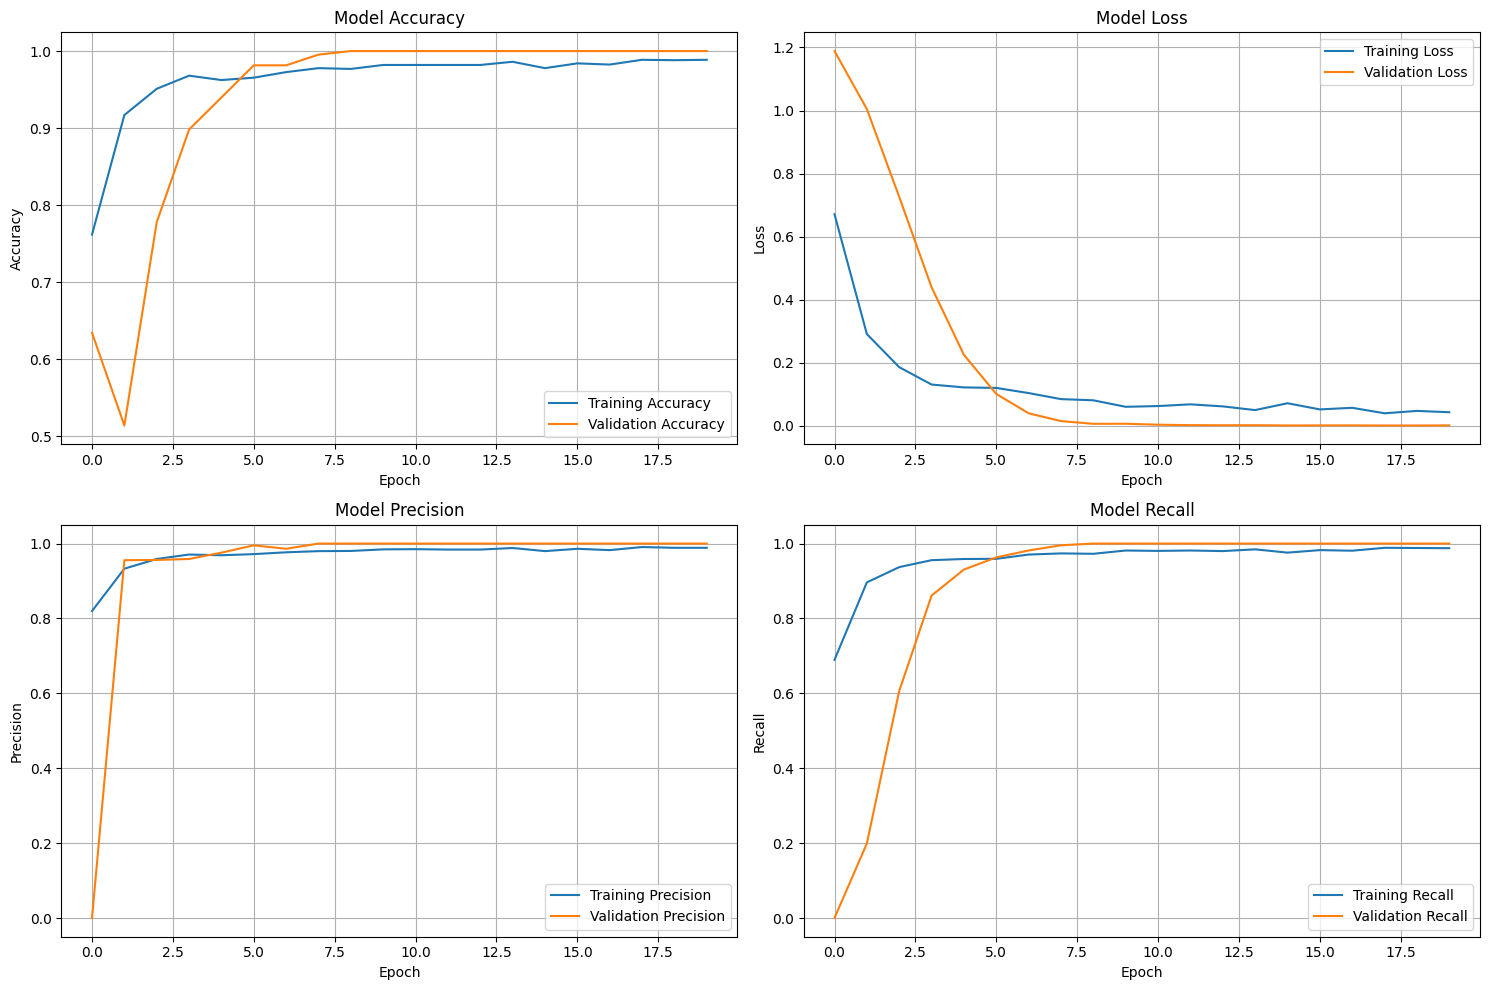

In [9]:
# Visualize training progress
plot_training_history(history)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.9944


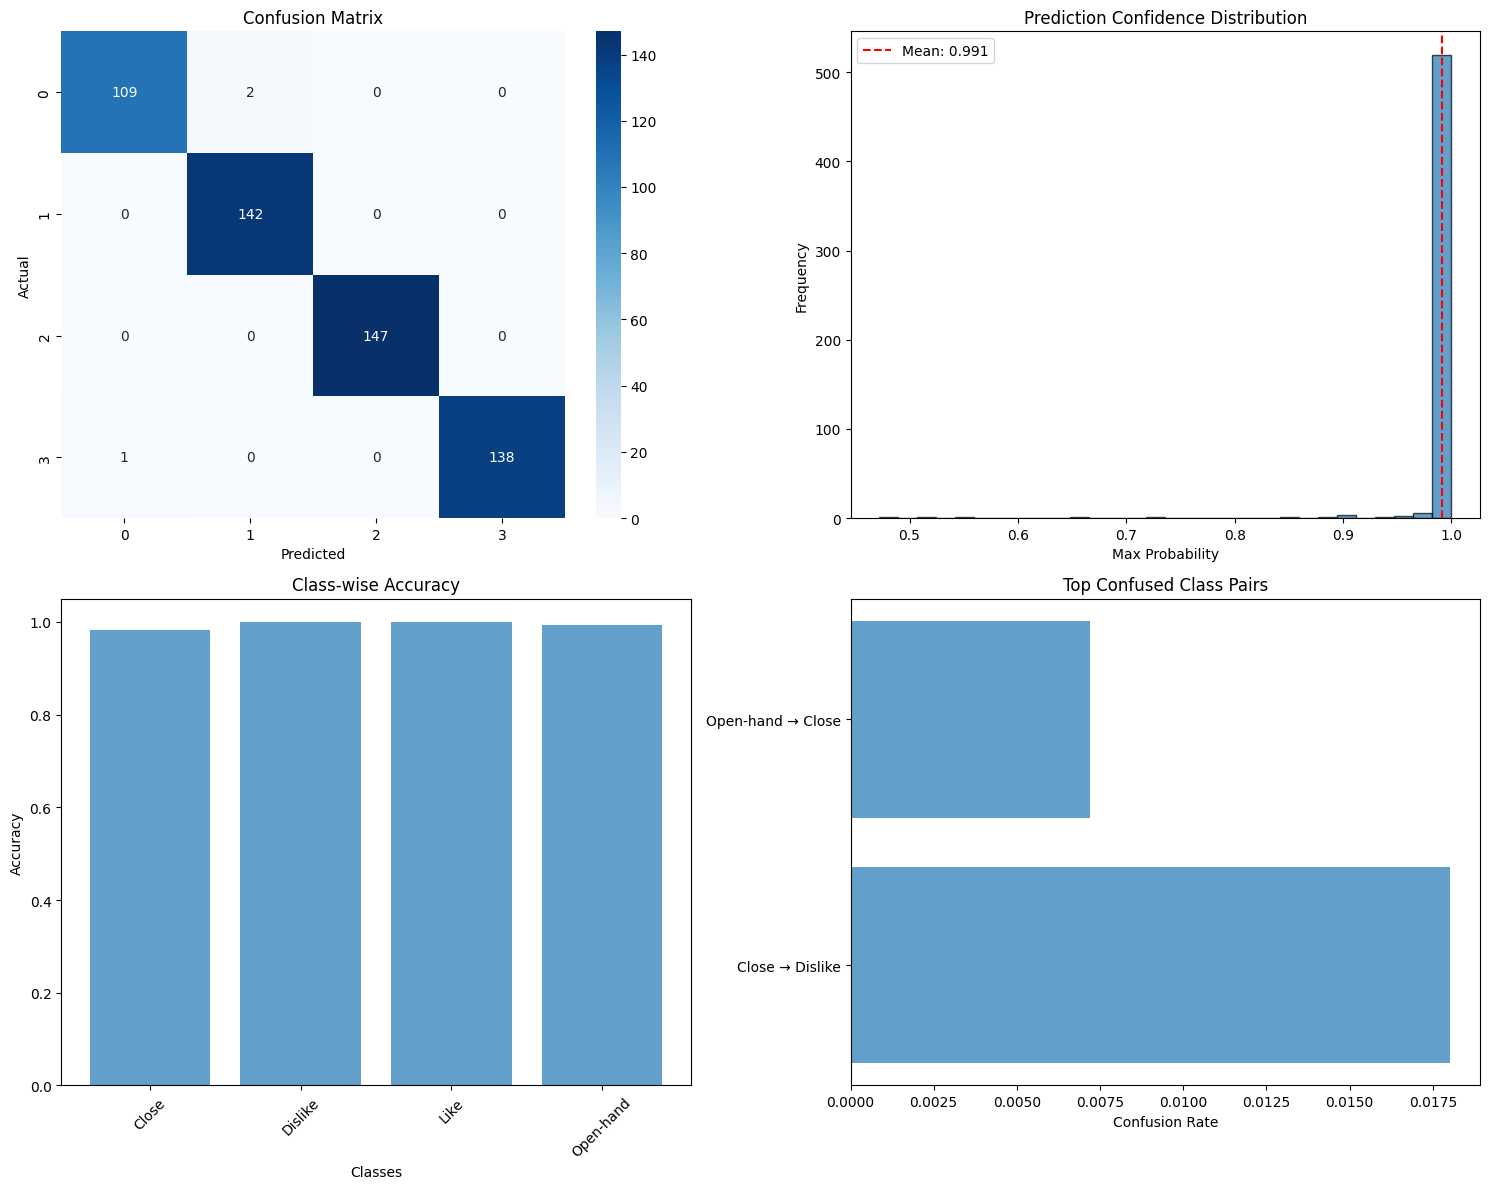


Classification Report:
              precision    recall  f1-score   support

       Close       0.99      0.98      0.99       111
     Dislike       0.99      1.00      0.99       142
        Like       1.00      1.00      1.00       147
   Open-hand       1.00      0.99      1.00       139

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



In [11]:
# Evaluate on test set with visualizations
class_names = list(label_encoder.classes_)
y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, class_names)

In [12]:
# Save the model
# Save with class information
model_info = {
    "input_dim": input_dim,
    "num_classes": num_classes,
    "class_names": label_encoder.classes_.tolist(),
}
save_model_complete(
    model, "gesture_classifier", save_history=history, model_info=model_info
)

model_dir = save_model_complete(
    model, model_name="gesture_classifier", save_history=history, model_info=model_info
)

Saving model to ../models/...
✓ Saved complete model (.keras)
✓ Saved complete model (.h5)
INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


Saved artifact at '../models/gesture_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  13653490176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13656998656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13653485600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13653487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657003760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657000064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657002880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657007808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657003056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657006576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657008864: TensorSpec(shape=(), dtype=

✓ Saved in SavedModel format
✓ Saved model weights
✓ Saved model architecture (JSON)
✓ Saved training history
✓ Saved model information
✓ Model saved successfully in ../models/
Saving model to ../models/...
✓ Saved complete model (.keras)
✓ Saved complete model (.h5)
INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


INFO:tensorflow:Assets written to: ../models/gesture_classifier_savedmodel/assets


Saved artifact at '../models/gesture_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  13653490176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13656998656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13653485600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13653487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657003760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657000064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657002880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657007808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657003056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657006576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13657008864: TensorSpec(shape=(), dtype=

In [17]:
# Function to convert you tensorflow model to tensorflow lite
# Since the code is using .tflite model, this step is essential
def convert_model_to_tflite(original_model_path, new_model_name):
    """
    Convert your H5 model to TensorFlow Lite (faster version)
    """
    print("Loading your original model...")
    model = tf.keras.models.load_model(original_model_path, compile=False)

    print("Converting to TensorFlow Lite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Makes it smaller and faster

    tflite_model = converter.convert()

    # ✅ Ensure directory exists
    os.makedirs(os.path.dirname(new_model_name), exist_ok=True)

    print("Saving new model...")
    with open(new_model_name, "wb") as f:
        f.write(tflite_model)

    print(f"✅ Done! New model saved as: {new_model_name}")
    return new_model_name

In [18]:
# Convert your model
original_path = "../models/gesture_classifier.h5"
new_model_path = "../models/tflite/gesture_classifier.tflite"

convert_model_to_tflite(original_path, new_model_path)

Loading your original model...
Converting to TensorFlow Lite...
INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmp7t1zv6hg/assets


INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmp7t1zv6hg/assets


Saved artifact at '/var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmp7t1zv6hg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  14587491104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587481952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587730000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587487408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13063042352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587493920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587394912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587391920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587395440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14587393680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14588881984: TensorS

W0000 00:00:1758146159.165540  225825 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758146159.165553  225825 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Saving new model...
✅ Done! New model saved as: ../models/tflite/gesture_classifier.tflite


'../models/tflite/gesture_classifier.tflite'